In [17]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
#import kagglehub
#paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')
#awsaf49_pneumonia_chest_xray_npy_path = kagglehub.dataset_download('awsaf49/pneumonia-chest-xray-npy')

#print('Data source import complete.')

In [18]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MendeleyData


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MendeleyData


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/MendeleyData/train'
test_dir = '/content/drive/MyDrive/MendeleyData/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    color_mode='grayscale',   # importante para que CovXNet funcione con (128,128,1)
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
!pip install -q covxnet --no-deps

In [21]:
#from covxnet import CovXNet128


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from covxnet import CovXNet128

# Paso 1: Se crea el modelo base (este tiene softmax al final)
model_base = CovXNet128(input_shape=(128, 128, 1), num_classes=1)

# Paso 2: Se eemplaza la capa de salida con una nueva con sigmoid
# Toma la penúltima capa del modelo (la anterior a softmax)
x = model_base.layers[-2].output
output = Dense(1, activation='sigmoid')(x)

# Paso 3: Se construye un nuevo modelo con la salida corregida
model = Model(inputs=model_base.input, outputs=output)

# Paso 4: Compílación
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [22]:
# CALLBACKS
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model

def get_callbacks():
    callback1 = ModelCheckpoint('covxnet128.h5', monitor='val_accuracy',
                                verbose=1, save_best_only=True, mode='max')
    callback2 = CSVLogger('covxnet128_log.csv')
    return [callback1, callback2]

In [23]:
# ENTRENAMIENTO
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular class_weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# Callbacks adicionales
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

# ENTRENAMIENTO FINAL
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=get_callbacks() + [early_stop, reduce_lr]
)


"""history = model.fit(
    train_generator,
    epochs=3,
    validation_data=test_generator,
    callbacks=get_callbacks()
)"""

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.7496 - loss: 0.4733
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to covxnet128.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 228s 652ms/step - accuracy: 0.7499 - loss: 0.4728 - val_accuracy: 0.6250 - val_loss: 0.7629 - learning_rate: 0.0010
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8864 - loss: 0.2798
Epoch 2: val_accuracy did not improve from 0.62500
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step - accuracy: 0.8864 - loss: 0.2797 - val_accuracy: 0.6250 - val_loss: 0.8697 - learning_rate: 0.0010
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9042 - loss: 0.2425
Epoch 3: val_accuracy did not improve from 0.62500
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step - accuracy: 0.9042 - loss: 0.2425 - val_accuracy: 0.6250 - val_loss: 1.0681 - learning_rate: 0.0010
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9074 - loss: 0.2201
Epoch 4: val_accuracy did not improve from 0.62500
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step - accuracy: 0.9074 - loss: 0.2201 - val_accuracy: 0.6250 - val_loss: 2.2136 - learning_rate: 0.0010
Epo

164/164 ━━━━━━━━━━━━━━━━━━━━ 54s 325ms/step - accuracy: 0.9234 - loss: 0.1905 - val_accuracy: 0.8446 - val_loss: 0.4647 - learning_rate: 3.0000e-04
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9229 - loss: 0.1778
Epoch 6: val_accuracy improved from 0.84455 to 0.85256, saving model to covxnet128.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9229 - loss: 0.1779 - val_accuracy: 0.8526 - val_loss: 0.3667 - learning_rate: 3.0000e-04
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9262 - loss: 0.1755
Epoch 7: val_accuracy did not improve from 0.85256
164/164 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.9262 - loss: 0.1755 - val_accuracy: 0.8205 - val_loss: 0.5061 - learning_rate: 3.0000e-04
Epoch 8/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9409 - loss: 0.1648
Epoch 8: val_accuracy did not improve from 0.85256
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.9408 - loss: 0.1649 - val_accuracy: 0.8478 - val_loss: 0.3463 - learning_rate: 3.0000e-04
Epoch 9/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9403 - loss: 0.1580
Epoch 9: val_accuracy did not improve from 0.85256
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9403 - loss: 0.1580 - val_accuracy: 0.8446 - val_loss: 0.3962 - learning_rate:

164/164 ━━━━━━━━━━━━━━━━━━━━ 54s 325ms/step - accuracy: 0.9376 - loss: 0.1646 - val_accuracy: 0.8862 - val_loss: 0.3185 - learning_rate: 3.0000e-04
Epoch 11/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9285 - loss: 0.1932
Epoch 11: val_accuracy did not improve from 0.88622
164/164 ━━━━━━━━━━━━━━━━━━━━ 52s 317ms/step - accuracy: 0.9286 - loss: 0.1930 - val_accuracy: 0.8093 - val_loss: 0.4633 - learning_rate: 3.0000e-04
Epoch 12/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9494 - loss: 0.1435
Epoch 12: val_accuracy did not improve from 0.88622
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9493 - loss: 0.1436 - val_accuracy: 0.8622 - val_loss: 0.3455 - learning_rate: 3.0000e-04
Epoch 13/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9414 - loss: 0.1602
Epoch 13: val_accuracy improved from 0.88622 to 0.89103, saving model to covxnet128.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 54s 326ms/step - accuracy: 0.9414 - loss: 0.1602 - val_accuracy: 0.8910 - val_loss: 0.3661 - learning_rate: 3.0000e-04
Epoch 14/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9459 - loss: 0.1323
Epoch 14: val_accuracy did not improve from 0.89103
164/164 ━━━━━━━━━━━━━━━━━━━━ 52s 317ms/step - accuracy: 0.9459 - loss: 0.1323 - val_accuracy: 0.8446 - val_loss: 0.4206 - learning_rate: 9.0000e-05
Epoch 15/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9509 - loss: 0.1318
Epoch 15: val_accuracy did not improve from 0.89103
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.9509 - loss: 0.1318 - val_accuracy: 0.8702 - val_loss: 0.3452 - learning_rate: 9.0000e-05
Epoch 16/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9435 - loss: 0.1418
Epoch 16: val_accuracy did not improve from 0.89103
164/164 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - accuracy: 0.9435 - loss: 0.1418 - val_accuracy: 0.8542 - val_loss: 0.3274 - learning

164/164 ━━━━━━━━━━━━━━━━━━━━ 54s 327ms/step - accuracy: 0.9575 - loss: 0.1165 - val_accuracy: 0.8958 - val_loss: 0.2728 - learning_rate: 2.7000e-05
Epoch 19/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9520 - loss: 0.1130
Epoch 19: val_accuracy did not improve from 0.89583
164/164 ━━━━━━━━━━━━━━━━━━━━ 53s 321ms/step - accuracy: 0.9521 - loss: 0.1130 - val_accuracy: 0.8862 - val_loss: 0.2930 - learning_rate: 2.7000e-05
Epoch 20/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9480 - loss: 0.1246
Epoch 20: val_accuracy did not improve from 0.89583
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 307ms/step - accuracy: 0.9480 - loss: 0.1246 - val_accuracy: 0.8766 - val_loss: 0.3094 - learning_rate: 2.7000e-05
Epoch 21/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9545 - loss: 0.1212
Epoch 21: val_accuracy did not improve from 0.89583
164/164 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.9545 - loss: 0.1212 - val_accuracy: 0.8830 - val_loss: 0.3132 - learning

'history = model.fit(\n    train_generator,\n    epochs=3,\n    validation_data=test_generator,\n    callbacks=get_callbacks()\n)'

In [24]:
# EVALUACIÓN
best_model = load_model('covxnet128.h5')
loss, acc = best_model.evaluate(test_generator)
print(f"Mejor modelo - Accuracy: {acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.8697 - loss: 0.3593
Mejor modelo - Accuracy: 0.8958


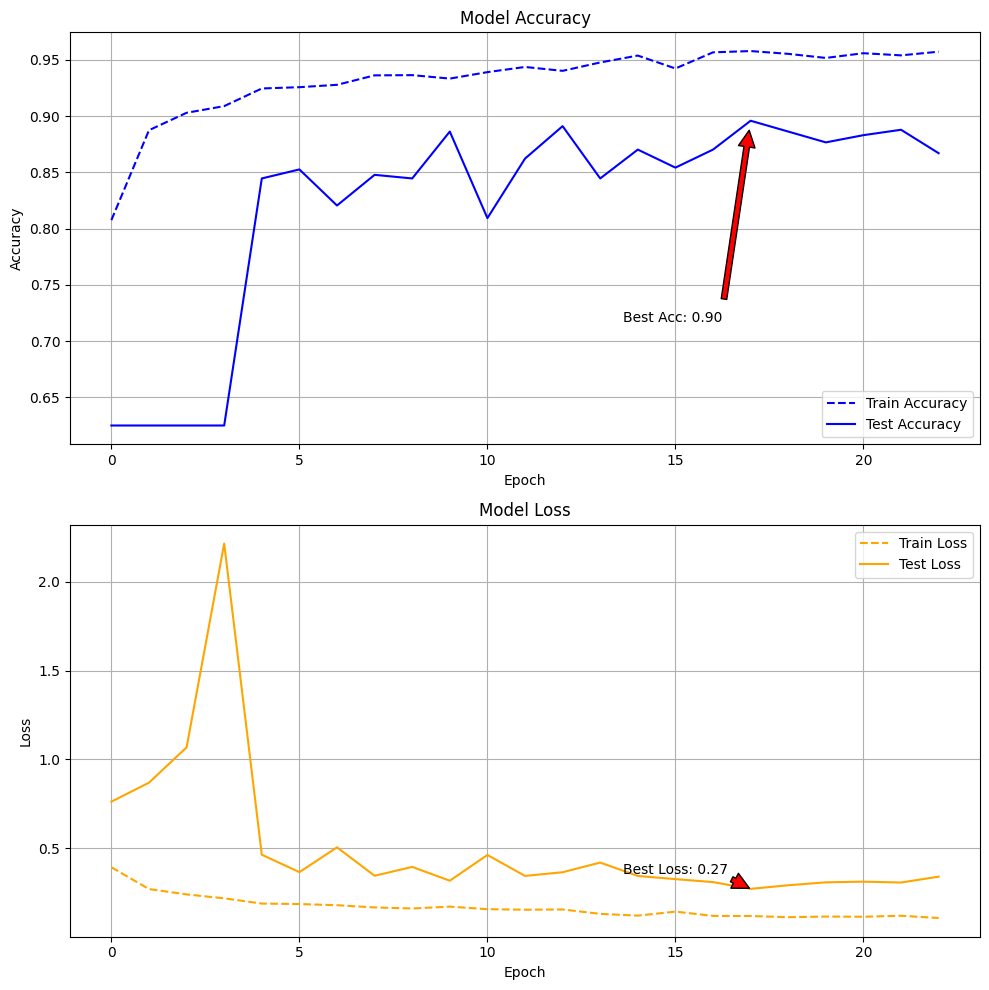

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='dashed')
axs[0].plot(history.history['val_accuracy'], label='Test Accuracy', color='blue')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].grid(True)

max_val_acc = np.max(history.history['val_accuracy'])
max_val_acc_epoch = np.argmax(history.history['val_accuracy'])
axs[0].annotate(f'Best Acc: {max_val_acc:.2f}',
                xy=(max_val_acc_epoch, max_val_acc),
                xytext=(max_val_acc_epoch*0.8, max_val_acc*0.8),
                arrowprops=dict(facecolor='red', shrink=0.05))

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Train Loss', color='orange', linestyle='dashed')
axs[1].plot(history.history['val_loss'], label='Test Loss', color='orange')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].grid(True)

min_val_loss = history.history['val_loss'][max_val_acc_epoch]
min_val_loss_epoch = max_val_acc_epoch
axs[1].annotate(f'Best Loss: {min_val_loss:.2f}',
                xy=(min_val_loss_epoch, min_val_loss),
                xytext=(min_val_loss_epoch*0.8, min_val_loss*1.3),
                arrowprops=dict(facecolor='red', shrink=0.05))

fig.tight_layout()
plt.show()

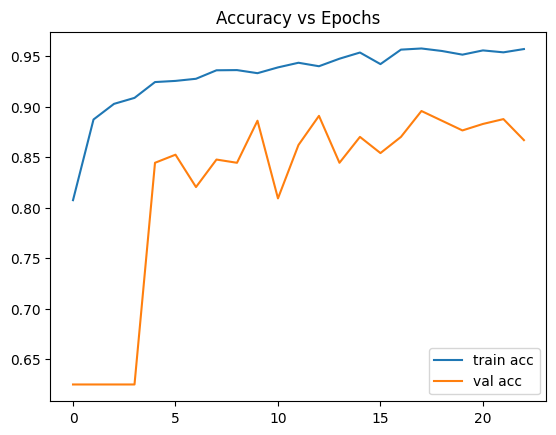

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 629ms/step
Matriz de Confusión:
[[190  44]
 [ 21 369]]


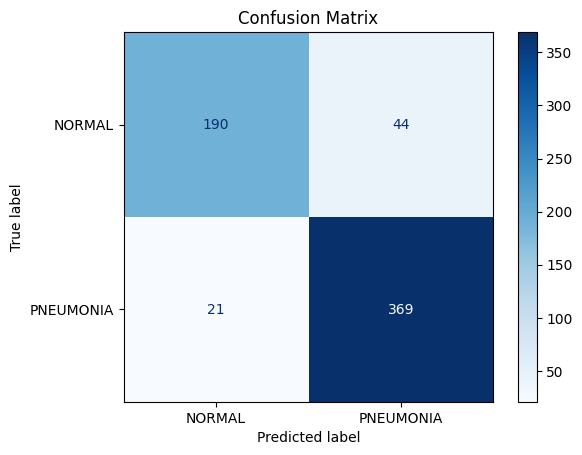


Reporte de Clasificación:
              precision    recall  f1-score   support

      NORMAL       0.90      0.81      0.85       234
   PNEUMONIA       0.89      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.89       624



In [29]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predicciones con el mejor modelo
y_pred_prob = best_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # binarizamos la salida sigmoid

# Etiquetas reales
y_true = test_generator.classes

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusión:")
print(cm)

# Etiquetas (ajusta si tu orden es distinto)
class_names = list(test_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Reporte detallado
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [27]:
import os

def count_images(directory):
    for label in os.listdir(directory):
        path = os.path.join(directory, label)
        if os.path.isdir(path):
            print(f'{label}: {len(os.listdir(path))} imágenes')

print("Train:")
count_images(train_dir)

print("Test:")
count_images(test_dir)


Train:
NORMAL: 1349 imágenes
PNEUMONIA: 3884 imágenes
Test:
PNEUMONIA: 390 imágenes
NORMAL: 234 imágenes
